                 connectionTime            disconnectTime  \
0     2018-04-25 11:08:04+00:00 2018-04-25 13:20:10+00:00   
1     2018-04-25 13:45:10+00:00 2018-04-26 00:56:16+00:00   
2     2018-04-25 13:45:50+00:00 2018-04-25 23:04:45+00:00   
3     2018-04-25 14:37:06+00:00 2018-04-25 23:55:34+00:00   
4     2018-04-25 14:40:34+00:00 2018-04-25 23:03:12+00:00   
...                         ...                       ...   
11794 2018-10-15 13:53:20+00:00 2018-10-15 23:10:02+00:00   
11795 2018-10-15 13:59:42+00:00 2018-10-15 23:39:56+00:00   
11796 2018-10-15 14:11:20+00:00 2018-10-15 23:54:33+00:00   
11797 2018-10-15 14:17:16+00:00 2018-10-16 04:45:33+00:00   
11798 2018-10-15 14:21:28+00:00 2018-10-16 00:38:26+00:00   

               doneChargingTime  session_duration  charge_duration  
0     2018-04-25 13:21:10+00:00          2.201667         2.218333  
1     2018-04-25 16:44:15+00:00         11.185000         2.984722  
2     2018-04-25 14:51:44+00:00          9.315278         1.

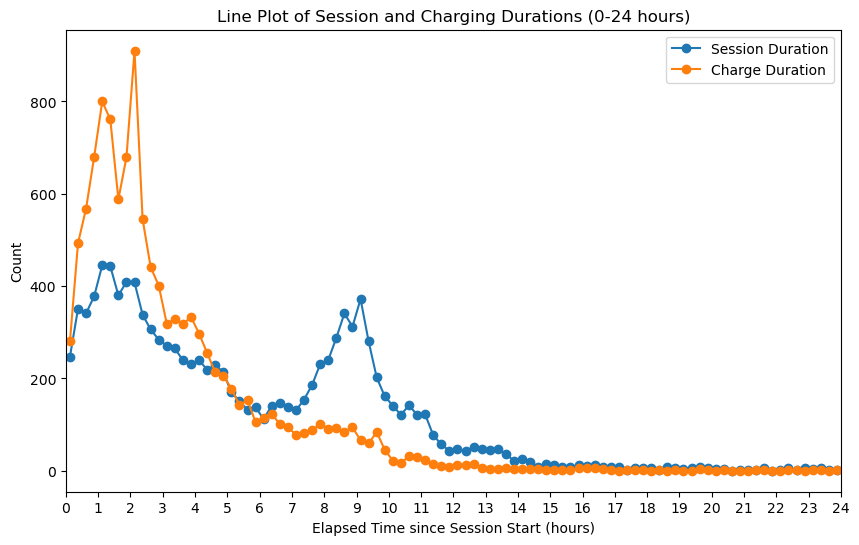

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Replace 'acndata_sessions.csv' with your CSV file path or URL
csv_file_path = 'acndata_sessions.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(csv_file_path)

# Convert the string time columns to datetime objects.
df['connectionTime'] = pd.to_datetime(df['connectionTime'], format='%a, %d %b %Y %H:%M:%S %Z')
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], format='%a, %d %b %Y %H:%M:%S %Z')
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], format='%a, %d %b %Y %H:%M:%S %Z')

# Compute the new columns (durations in hours)
df['session_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600.0
df['charge_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600.0

# Optional: inspect the dataframe with the new columns
print(df[['connectionTime', 'disconnectTime', 'doneChargingTime', 'session_duration', 'charge_duration']])

# Filter out sessions where any duration is greater than 24 hours.
df = df[(df['session_duration'] <= 24) & (df['charge_duration'] <= 24)]

# Define fine bins with 15-minute intervals (0.25 hours)
bins = np.arange(0, 24.25, 0.25)  # bins edges: 0, 0.25, 0.5, ..., 24

# Compute counts for each bin for both durations
session_counts, _ = np.histogram(df['session_duration'], bins=bins)
charge_counts, _ = np.histogram(df['charge_duration'], bins=bins)

# Compute midpoints of each bin for plotting the line
bin_midpoints = (bins[:-1] + bins[1:]) / 2

# Create a line plot for the absolute counts in each bin
plt.figure(figsize=(10, 6))

# Plot session duration counts as a line
plt.plot(bin_midpoints, session_counts, marker='o', label='Session Duration')

# Plot charge duration counts as a line
plt.plot(bin_midpoints, charge_counts, marker='o', label='Charge Duration')

# Adjust x-axis to cover a 24-hour period and label ticks every hour
plt.xlim(0, 24)
plt.xticks(np.arange(0, 25, 1))

plt.title('Line Plot of Session and Charging Durations (0-24 hours)')
plt.xlabel('Elapsed Time since Session Start (hours)')
plt.ylabel('Count')
plt.legend()

plt.show()


In [41]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime


df1 = pd.read_csv('acndata_sessions.csv')
# Load the extra data for 2019
df2 = pd.read_csv('MONTHS\CSV_2019\Combined.csv')  # use raw string for Windows paths

# Combine the datasets vertically
df = pd.concat([df1, df2], ignore_index=True)

df.dropna(subset=['sessionID', 'connectionTime', 'disconnectTime', 'doneChargingTime', 'kWhDelivered'], inplace=True)

for col in ['connectionTime', 'disconnectTime', 'doneChargingTime']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df.dropna(subset=['connectionTime', 'disconnectTime'], inplace=True)

df['charge_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600.0
df['connect_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600.0

#df = df[(df['connect_duration'] > 0) & (df['connect_duration'] < 12)]


df['hour'] = (df['connectionTime'].dt.hour - 8) % 24


arrival_rate = df.groupby('hour').size()
avg_charge_duration = df.groupby('hour')['charge_duration'].mean()
avg_connect_duration = df.groupby('hour')['connect_duration'].mean()



df = df[df['charge_duration'] > 0]

df['power_output'] = df['kWhDelivered'] / df['charge_duration']


df_start = df[['connectionTime', 'power_output']].copy()
df_start.rename(columns={'connectionTime': 'timestamp'}, inplace=True)

df_end = df[['doneChargingTime', 'power_output']].copy()
df_end.rename(columns={'doneChargingTime': 'timestamp'}, inplace=True)
df_end['power_output'] = -df_end['power_output']


events_df = pd.concat([df_start, df_end]).sort_values('timestamp')

events_df['total_power'] = events_df['power_output'].cumsum()

events_df = events_df.set_index('timestamp')

daily_avg = events_df['total_power'].resample('D').mean().reset_index()


fig_demand = px.scatter(daily_avg,
                     x='timestamp',
                     y='total_power',
                     labels={'timestamp': 'Date', 'total_power': 'Average System Demand (kW)'},
                     title='Average kW Demand of the Garage Throughout the Year')
fig_demand.show()


<>:10: SyntaxWarning:

invalid escape sequence '\C'

<>:10: SyntaxWarning:

invalid escape sequence '\C'

C:\Users\bartm\AppData\Local\Temp\ipykernel_4176\894504299.py:10: SyntaxWarning:

invalid escape sequence '\C'



In [39]:
import pandas as pd
import plotly.express as px

# Read the CSV file
df = pd.read_csv('MONTHS\CSV_2019\Combined.csv')

# Drop rows with missing critical information
df.dropna(subset=['sessionID', 'connectionTime', 'disconnectTime', 'doneChargingTime', 'kWhDelivered'], inplace=True)

# Convert string time columns to datetime objects
for col in ['connectionTime', 'disconnectTime', 'doneChargingTime']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where connectionTime or disconnectTime conversion failed
df.dropna(subset=['connectionTime', 'disconnectTime'], inplace=True)

# Calculate the durations (in hours)
df['charge_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600.0
df['connect_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600.0

# Create an 'hour' column based on connection time (adjusted with a modulus shift if needed)
df['hour'] = (df['connectionTime'].dt.hour - 8) % 24

# Optional groupings (arrival rate, average durations by hour)
arrival_rate = df.groupby('hour').size()
avg_charge_duration = df.groupby('hour')['charge_duration'].mean()
avg_connect_duration = df.groupby('hour')['connect_duration'].mean()

# Filter out rows with non-positive charge durations
df = df[df['charge_duration'] > 0]

# Compute power output in kW (kWh delivered divided by charge duration in hours)
df['power_output'] = df['kWhDelivered'] / df['charge_duration']

# Create events DataFrames for session start and end, then combine them.
df_start = df[['connectionTime', 'power_output']].copy()
df_start.rename(columns={'connectionTime': 'timestamp'}, inplace=True)

df_end = df[['doneChargingTime', 'power_output']].copy()
df_end.rename(columns={'doneChargingTime': 'timestamp'}, inplace=True)
df_end['power_output'] = -df_end['power_output']

# Concatenate start and end events; sort them by time
events_df = pd.concat([df_start, df_end]).sort_values('timestamp')

# Compute cumulative total power over time
events_df['total_power'] = events_df['power_output'].cumsum()

# Set the timestamp column as the index
events_df = events_df.set_index('timestamp')

# Resample to compute daily average total power
daily_avg = events_df['total_power'].resample('D').mean().reset_index()

# Exclude Saturdays and Sundays from the daily average
# .dt.dayofweek returns 0 for Monday, ... 6 for Sunday.
daily_avg = daily_avg[daily_avg['timestamp'].dt.dayofweek < 5]

# Plot using Plotly Express as a scatter plot
fig_demand = px.scatter(
    daily_avg,
    x='timestamp',
    y='total_power',
    labels={'timestamp': 'Date', 'total_power': 'Average System Demand (kW)'},
    title='Average kW Demand of the Garage Throughout the Year (Weekdays Only)'
)

fig_demand.show()


<>:5: SyntaxWarning:

invalid escape sequence '\C'

<>:5: SyntaxWarning:

invalid escape sequence '\C'

C:\Users\bartm\AppData\Local\Temp\ipykernel_4176\1390973633.py:5: SyntaxWarning:

invalid escape sequence '\C'



In [ ]:
import pandas as pd
import plotly.express as px

# Read the CSV file
df = pd.read_csv('acndata_sessions.csv')

# Drop rows with missing critical information
df.dropna(subset=['sessionID', 'connectionTime', 'disconnectTime', 'doneChargingTime', 'kWhDelivered'], inplace=True)

# Convert string time columns to datetime objects (coercing errors when necessary)
for col in ['connectionTime', 'disconnectTime', 'doneChargingTime']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where connectionTime or disconnectTime conversion failed
df.dropna(subset=['connectionTime', 'disconnectTime'], inplace=True)

# Calculate the durations (in hours)
df['charge_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600.0
df['connect_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600.0


# Filter out rows with non-positive charge durations
df = df[df['charge_duration'] > 0]

# Compute power output in kW
df['power_output'] = df['kWhDelivered'] / df['charge_duration']

# Create events DataFrames for charging start and end,
# with start adding power and end subtracting power.
df_start = df[['connectionTime', 'power_output']].copy()
df_start.rename(columns={'connectionTime': 'timestamp'}, inplace=True)

df_end = df[['doneChargingTime', 'power_output']].copy()
df_end.rename(columns={'doneChargingTime': 'timestamp'}, inplace=True)
df_end['power_output'] = -df_end['power_output']

# Combine events and sort by timestamp
events_df = pd.concat([df_start, df_end]).sort_values('timestamp')
events_df['total_power'] = events_df['power_output'].cumsum()
events_df = events_df.set_index('timestamp')

# Resample to compute daily average demand (total power)
daily_avg = events_df['total_power'].resample('D').mean().reset_index()

# Exclude weekends (Saturday=5, Sunday=6)
daily_avg = daily_avg[daily_avg['timestamp'].dt.dayofweek < 5]

# Create a list of holiday dates (2018) to exclude:
holidays = pd.to_datetime([
    '2018-01-01',  # New Year's Day (Monday, January 1)
    '2018-01-15',  # Martin Luther King Jr. Day (Monday, January 15)
    '2018-02-19',  # Washington's Birthday / Presidents' Day (Monday, February 19)
    '2018-05-28',  # Memorial Day (Monday, May 28)
    '2018-07-04',  # Independence Day (Wednesday, July 4)
    '2018-09-03',  # Labor Day (Monday, September 3)
    '2018-10-08',  # Columbus Day (Monday, October 8)
    '2018-11-12',  # Veterans Day observed (Monday, November 12)
    '2018-11-22',  # Thanksgiving Day (Thursday, November 22)
    '2018-12-25'   # Christmas Day (Tuesday, December 25)
])

# Exclude the holiday dates from the daily averages
daily_avg = daily_avg[~daily_avg['timestamp'].isin(holidays)]

# Plot the daily average demand (excluding weekends and holidays) using Plotly Express
fig_demand = px.scatter(
    daily_avg,
    x='timestamp',
    y='total_power',
    labels={'timestamp': 'Date', 'total_power': 'Average System Demand (kW)'},
    title='Average kW Demand of the Garage Throughout the Year (Weekdays & Non-Holiday Only)'
)

fig_demand.show()


<>:12: SyntaxWarning:

invalid escape sequence '\C'

<>:12: SyntaxWarning:

invalid escape sequence '\C'

C:\Users\bartm\AppData\Local\Temp\ipykernel_4176\2669313860.py:12: SyntaxWarning:

invalid escape sequence '\C'



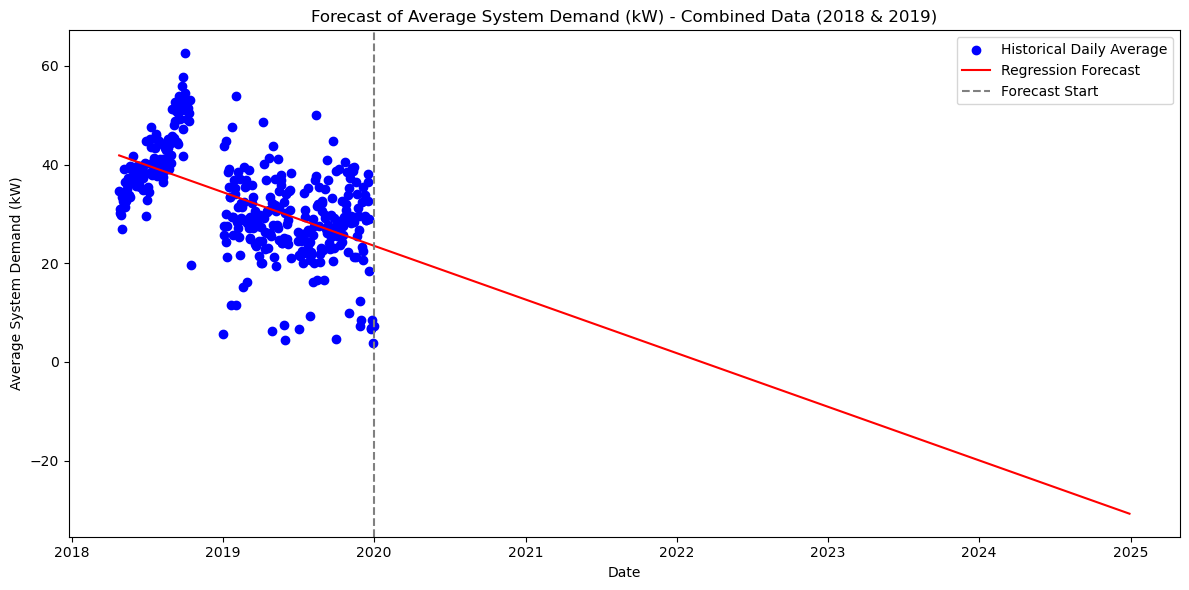

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# --------------------------------------
# 1. Load and Combine the Two Data Sources
# --------------------------------------
# Load the original dataset (e.g., for 2018)
df1 = pd.read_csv('acndata_sessions.csv')
# Load the extra data for 2019
df2 = pd.read_csv('MONTHS\CSV_2019\Combined.csv')  # use raw string for Windows paths

# Combine the datasets vertically
df = pd.concat([df1, df2], ignore_index=True)

df.dropna(subset=['sessionID', 'connectionTime', 'disconnectTime', 'doneChargingTime', 'kWhDelivered'], inplace=True)

# Convert time columns from strings to datetime objects.
for col in ['connectionTime', 'disconnectTime', 'doneChargingTime']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where conversion failed for essential timestamps.
df.dropna(subset=['connectionTime', 'disconnectTime'], inplace=True)

# Compute session and charging durations (in hours)
df['charge_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600.0
df['connect_duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600.0

# Optionally, create an 'hour' column based on connection time (shifted by 8 hours modulo 24)
df['hour'] = (df['connectionTime'].dt.hour - 8) % 24

# Filter out sessions with non-positive charging duration.
df = df[df['charge_duration'] > 0]

# Calculate power output (in kW) for each session.
df['power_output'] = df['kWhDelivered'] / df['charge_duration']

# --------------------------------------
# 3. Create an Event-Based Time Series
# --------------------------------------
# Create events for charging start (positive power output)
df_start = df[['connectionTime', 'power_output']].copy()
df_start.rename(columns={'connectionTime': 'timestamp'}, inplace=True)

# Create events for charging end (negative power output)
df_end = df[['doneChargingTime', 'power_output']].copy()
df_end.rename(columns={'doneChargingTime': 'timestamp'}, inplace=True)
df_end['power_output'] = -df_end['power_output']

# Combine start and end events and sort them by timestamp.
events_df = pd.concat([df_start, df_end]).sort_values('timestamp')
events_df['total_power'] = events_df['power_output'].cumsum()
events_df = events_df.set_index('timestamp')

# --------------------------------------
# 4. Compute Daily Average System Demand
# --------------------------------------
# Resample the events series to compute the daily average total power.
daily_avg = events_df['total_power'].resample('D').mean().reset_index()

# Exclude weekends (Saturday = 5, Sunday = 6).
daily_avg = daily_avg[daily_avg['timestamp'].dt.dayofweek < 5]

# Define a list of holidays (based on the provided dates for 2018).
holidays = pd.to_datetime([
    '2018-01-01',  # New Year's Day: Monday, January 1
    '2018-01-15',  # Martin Luther King Jr. Day: Monday, January 15
    '2018-02-19',  # Washington's Birthday (Presidents' Day): Monday, February 19
    '2018-05-28',  # Memorial Day: Monday, May 28
    '2018-07-04',  # Independence Day: Wednesday, July 4
    '2018-09-03',  # Labor Day: Monday, September 3
    '2018-10-08',  # Columbus Day: Monday, October 8
    '2018-11-12',  # Veterans Day (observed): Monday, November 12
    '2018-11-22',  # Thanksgiving Day: Thursday, November 22
    '2018-12-25'   # Christmas Day: Tuesday, December 25
])
daily_avg = daily_avg[~daily_avg['timestamp'].isin(holidays)]

# Drop any days with NaN as their daily average (e.g., days with no events).
daily_avg.dropna(subset=['total_power'], inplace=True)

# --------------------------------------
# 5. Fit a Regression Model and Forecast 5 Years
# --------------------------------------
# Convert timestamps to numeric values (days since first observation) for regression.
min_date = daily_avg['timestamp'].min()
daily_avg['days'] = (daily_avg['timestamp'] - min_date).dt.days

# Prepare the training data.
X_train = daily_avg['days'].values.reshape(-1, 1)
y_train = daily_avg['total_power'].values

# Fit a linear regression model to the historical data.
model = LinearRegression()
model.fit(X_train, y_train)

# Forecast for the next 5 years (approximately 5 * 365 = 1825 days).
forecast_days = 1825
last_day = daily_avg['days'].max()
X_pred = np.arange(0, last_day + forecast_days + 1).reshape(-1, 1)
y_pred = model.predict(X_pred)

# Convert numeric day predictions back to datetime objects.
dates_pred = [min_date + pd.Timedelta(days=int(x)) for x in X_pred.flatten()]

# --------------------------------------
# 6. Plot the Historical Data and 5-Year Forecast
# --------------------------------------
plt.figure(figsize=(12, 6))
# Plot historical daily average demand (blue scatter points).
plt.scatter(daily_avg['timestamp'], daily_avg['total_power'], color='blue', label='Historical Daily Average')
# Plot the regression forecast as a red line (covers historical and forecasted data).
plt.plot(dates_pred, y_pred, color='red', label='Regression Forecast')
# Mark the start of the forecast period.
forecast_start_date = min_date + pd.Timedelta(days=last_day)
plt.axvline(forecast_start_date, color='grey', linestyle='--', label='Forecast Start')

plt.title('Forecast of Average System Demand (kW) - Combined Data (2018 & 2019)')
plt.xlabel('Date')
plt.ylabel('Average System Demand (kW)')
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.express as px

df = pd.read_csv('acndata_sessions.csv')
df.dropna(subset=['sessionID', 'connectionTime', 'disconnectTime', 'doneChargingTime', 'kWhDelivered'], inplace=True)

for col in ['connectionTime', 'disconnectTime', 'doneChargingTime']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where conversion failed for connectionTime or disconnectTime.
df.dropna(subset=['connectionTime', 'disconnectTime'], inplace=True)

df['charge_duration'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600.0

df = df[df['charge_duration'] > 0]

# Compute the power output (kW) for each session.
df['power_output'] = df['kWhDelivered'] / df['charge_duration']

# -------------------------------
# 2. Build the Event-Based Time Series
# -------------------------------
# Create two event DataFrames for session start (positive power) and end (negative power)
df_start = df[['connectionTime', 'power_output']].copy()
df_start.rename(columns={'connectionTime': 'timestamp'}, inplace=True)

df_end = df[['doneChargingTime', 'power_output']].copy()
df_end.rename(columns={'doneChargingTime': 'timestamp'}, inplace=True)
df_end['power_output'] = -df_end['power_output']

# Concatenate events and sort by timestamp.
events_df = pd.concat([df_start, df_end]).sort_values('timestamp')
events_df['total_power'] = events_df['power_output'].cumsum()
events_df = events_df.set_index('timestamp')

# Resample to compute the daily average total power.
daily_avg = events_df['total_power'].resample('D').mean().reset_index()

# -------------------------------
# 3. Exclude Weekends and Specific Holidays
# -------------------------------
# Exclude weekends (Saturday=5, Sunday=6)
daily_avg = daily_avg[daily_avg['timestamp'].dt.dayofweek < 5]

# Define holidays (using 2018 dates based on your list)
holidays = pd.to_datetime([
    '2018-01-01',  # New Year's Day: Monday, January 1
    '2018-01-15',  # Martin Luther King Jr. Day: Monday, January 15
    '2018-02-19',  # Washington's Birthday / Presidents' Day: Monday, February 19
    '2018-05-28',  # Memorial Day: Monday, May 28
    '2018-07-04',  # Independence Day: Wednesday, July 4
    '2018-09-03',  # Labor Day: Monday, September 3
    '2018-10-08',  # Columbus Day: Monday, October 8
    '2018-11-12',  # Veterans Day (observed): Monday, November 12
    '2018-11-22',  # Thanksgiving Day: Thursday, November 22
    '2018-12-25'   # Christmas Day: Tuesday, December 25
])
exclude = pd.to_datetime(['2018-10-15'])
daily_avg = daily_avg[~daily_avg['timestamp'].isin(holidays)]
daily_avg = daily_avg[~daily_avg['timestamp'].isin(exclude)]

# -------------------------------
# 4. Fit a Linear Regression Model and Forecast
# -------------------------------
# Convert the timestamp to a numeric value (days since start) for regression.
min_date = daily_avg['timestamp'].min()
min_date = pd.Timestamp(min_date)  # Ensure it's a pandas Timestamp

daily_avg['days'] = (daily_avg['timestamp'] - min_date).dt.days

# Prepare training data for regression.
X_train = daily_avg['days'].values.reshape(-1, 1)
y_train = daily_avg['total_power'].values

# Fit the linear regression model.
model = LinearRegression()
model.fit(X_train, y_train)

# Forecast for the next period (here using 365 days; update to 1825 for a full 5-year forecast if needed).
forecast_days = 365  
last_day = daily_avg['days'].max()
X_pred = np.arange(0, last_day + forecast_days + 1).reshape(-1, 1)
y_pred = model.predict(X_pred)

# Convert numeric predictions back to datetime.
dates_pred = [min_date + pd.Timedelta(days=int(x)) for x in X_pred.flatten()]

# Create a DataFrame for predictions.
df_pred = pd.DataFrame({
    'timestamp': dates_pred,
    'predicted_total_power': y_pred
})


# -------------------------------
# 5. Plot with Plotly Express

fig = px.scatter(daily_avg, 
                 x='timestamp', 
                 y='total_power', 
                 title='Forecast of Average System Demand (kW): Historical Data & Prediction',
                 labels={'timestamp': 'Date', 'total_power': 'Average System Demand (kW)'})

# Add the regression forecast as a line.
fig.add_scatter(x=df_pred['timestamp'], 
                y=df_pred['predicted_total_power'], 
                mode='lines', 
                name='Regression Forecast')

fig.show()

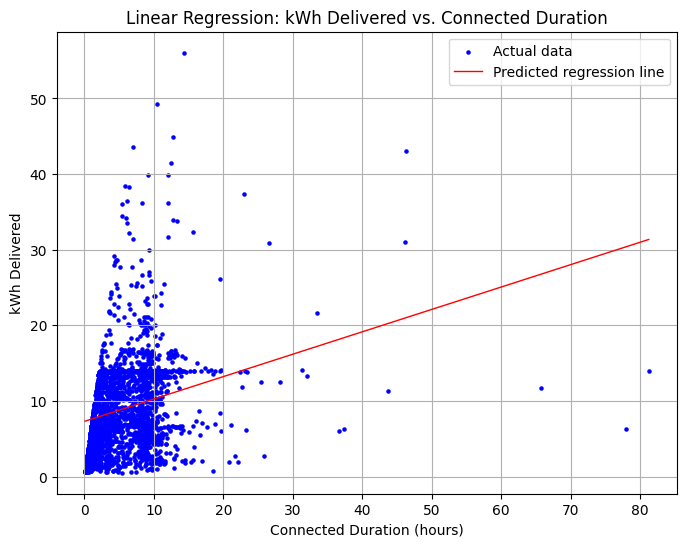

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# After training your model (see the previous code snippet):
# model = LinearRegression()
# model.fit(X_train, y_train)

# 1. Predict on the test set
y_pred = model.predict(X_test)

# 2. Create a scatter plot for the actual test data
plt.figure(figsize=(8, 6))
plt.scatter(X_test['connected_duration_hours'], y_test, color='blue', s=5, label='Actual data')

# 3. Sort the test set by 'connected_duration_hours' so we can draw a proper line
X_test_sorted = X_test.sort_values(by='connected_duration_hours')
y_pred_sorted = model.predict(X_test_sorted)

# 4. Plot the regression line
plt.plot(X_test_sorted['connected_duration_hours'], y_pred_sorted, color='red', linewidth=1, label='Predicted regression line')

# 5. Label the axes and add a title
plt.xlabel('Connected Duration (hours)')
plt.ylabel('kWh Delivered')
plt.title('Linear Regression: kWh Delivered vs. Connected Duration')
plt.legend()
plt.grid(True)

# 6. Display the plot
plt.show()

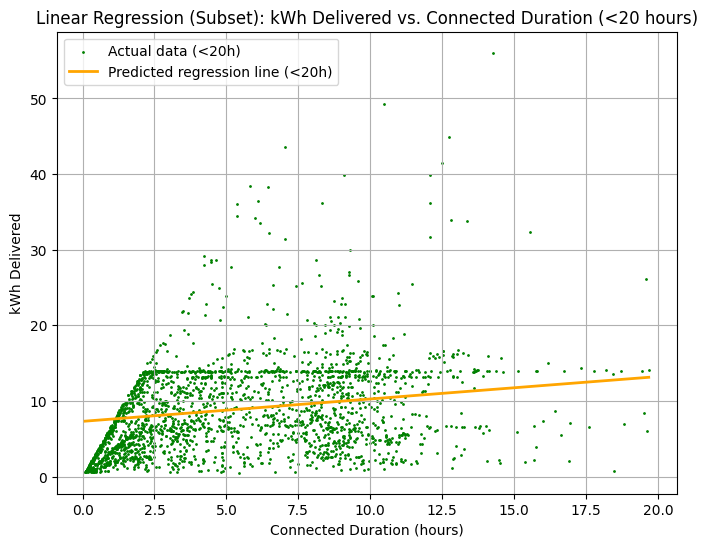

In [5]:
# Filter test set to only include sessions shorter than 20 hours
mask = X_test['connected_duration_hours'] < 20
X_test_filtered = X_test[mask]
y_test_filtered = y_test[mask]

# Sort the filtered set for a proper regression line
X_test_filtered_sorted = X_test_filtered.sort_values(by='connected_duration_hours')
y_pred_filtered_sorted = model.predict(X_test_filtered_sorted)

# Plot the filtered data
plt.figure(figsize=(8, 6))
plt.scatter(X_test_filtered['connected_duration_hours'], y_test_filtered, color='green', s=1, label='Actual data (<20h)')
plt.plot(X_test_filtered_sorted['connected_duration_hours'], y_pred_filtered_sorted, color='orange', linewidth=2, label='Predicted regression line (<20h)')

# Labeling
plt.xlabel('Connected Duration (hours)')
plt.ylabel('kWh Delivered')
plt.title('Linear Regression (Subset): kWh Delivered vs. Connected Duration (<20 hours)')
plt.legend()
plt.grid(True)

plt.show()


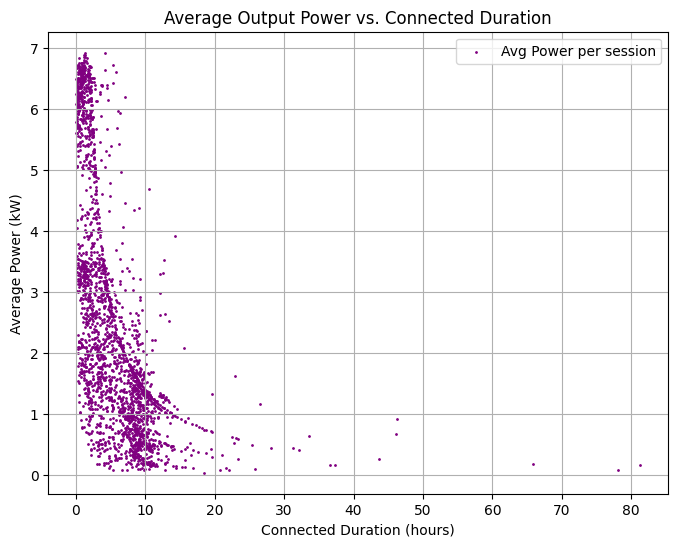

In [6]:
# Calculate average power for each test sample
average_power = y_test / X_test['connected_duration_hours']

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(X_test['connected_duration_hours'], average_power, color='purple', s=1, label='Avg Power per session')

# Labeling
plt.xlabel('Connected Duration (hours)')
plt.ylabel('Average Power (kW)')
plt.title('Average Output Power vs. Connected Duration')
plt.grid(True)
plt.legend()

plt.show()


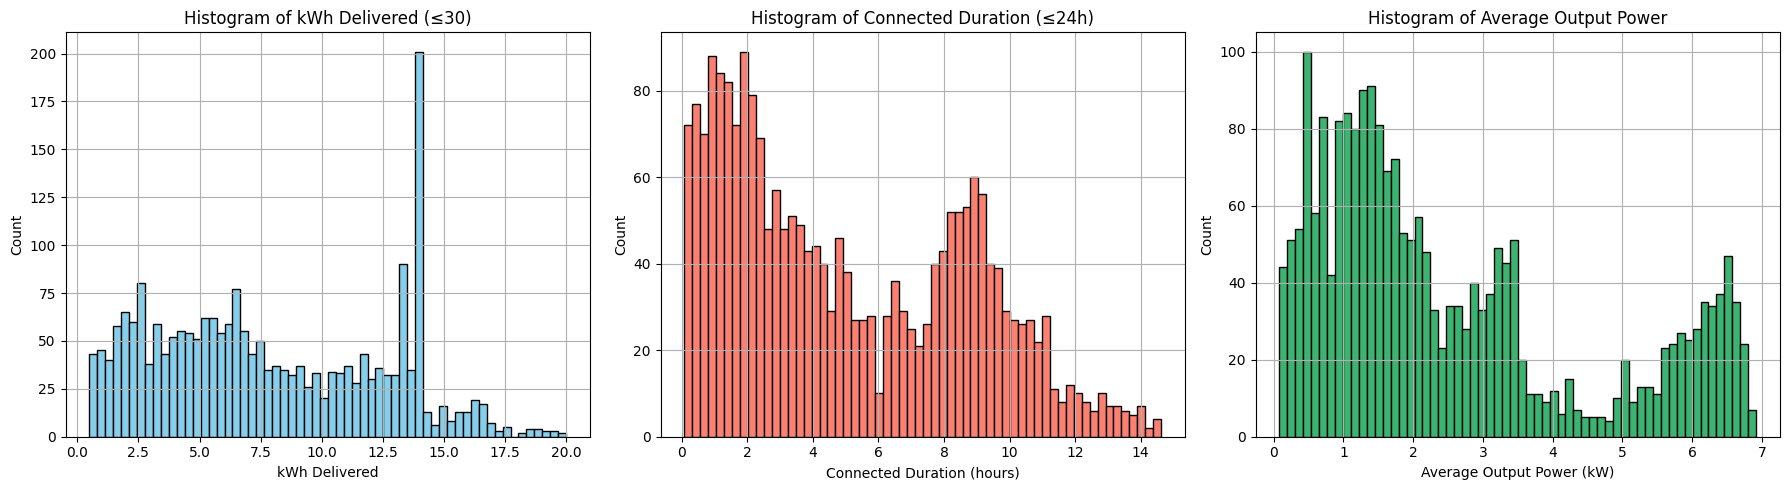

In [7]:
# Compute average power (kW)
average_power = y_test / X_test['connected_duration_hours']

# Apply filters: max 24h duration, max 30 kWh
mask = (X_test['connected_duration_hours'] <= 15) & (y_test <= 20)
filtered_duration = X_test['connected_duration_hours'][mask]
filtered_kwh = y_test[mask]
filtered_avg_power = average_power[mask]

plt.figure(figsize=(18, 5))

# 1. Histogram for kWh Delivered
plt.subplot(1, 3, 1)
plt.hist(filtered_kwh, bins=60, color='skyblue', edgecolor='black')
plt.xlabel('kWh Delivered')
plt.ylabel('Count')
plt.title('Histogram of kWh Delivered (≤30)')
plt.grid(True)

# 2. Histogram for Connected Duration
plt.subplot(1, 3, 2)
plt.hist(filtered_duration, bins=60, color='salmon', edgecolor='black')
plt.xlabel('Connected Duration (hours)')
plt.ylabel('Count')
plt.title('Histogram of Connected Duration (≤24h)')
plt.grid(True)

# 3. Histogram for Average Power
plt.subplot(1, 3, 3)
plt.hist(filtered_avg_power, bins=60, color='mediumseagreen', edgecolor='black')
plt.xlabel('Average Output Power (kW)')
plt.ylabel('Count')
plt.title('Histogram of Average Output Power')
plt.grid(True)

plt.tight_layout()
plt.show()


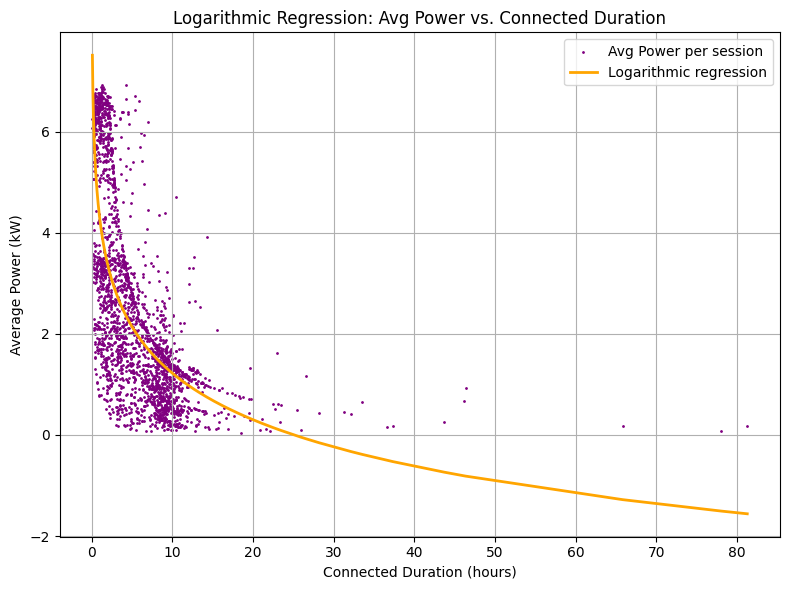

Logarithmic Regression:
MSE = 1.9344, R² = 0.5012


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Calculate average power
average_power = y_test / X_test['connected_duration_hours']
connected_duration = X_test['connected_duration_hours']

# Filter out invalid values
mask = (connected_duration > 0) & (average_power > 0)
x = connected_duration[mask].values.reshape(-1, 1)
y = average_power[mask].values

# Apply logarithmic transformation to x
x_log = np.log(x)

# Fit the logarithmic model: y = β0 + β1 * log(x)
model_log = LinearRegression()
model_log.fit(x_log, y)

# Create a smooth line: sort x, then predict using log(x)
x_sorted = np.sort(x.flatten())
x_log_sorted = np.log(x_sorted).reshape(-1, 1)
y_pred_sorted = model_log.predict(x_log_sorted)

# Evaluate model performance
y_pred_all = model_log.predict(x_log)
mse = mean_squared_error(y, y_pred_all)
r2 = r2_score(y, y_pred_all)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='purple', s=1, label='Avg Power per session')
plt.plot(x_sorted, y_pred_sorted, color='orange', linewidth=2, label='Logarithmic regression')

# Labels and legend
plt.xlabel('Connected Duration (hours)')
plt.ylabel('Average Power (kW)')
plt.title('Logarithmic Regression: Avg Power vs. Connected Duration')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print performance
print(f"Logarithmic Regression:\nMSE = {mse:.4f}, R² = {r2:.4f}")


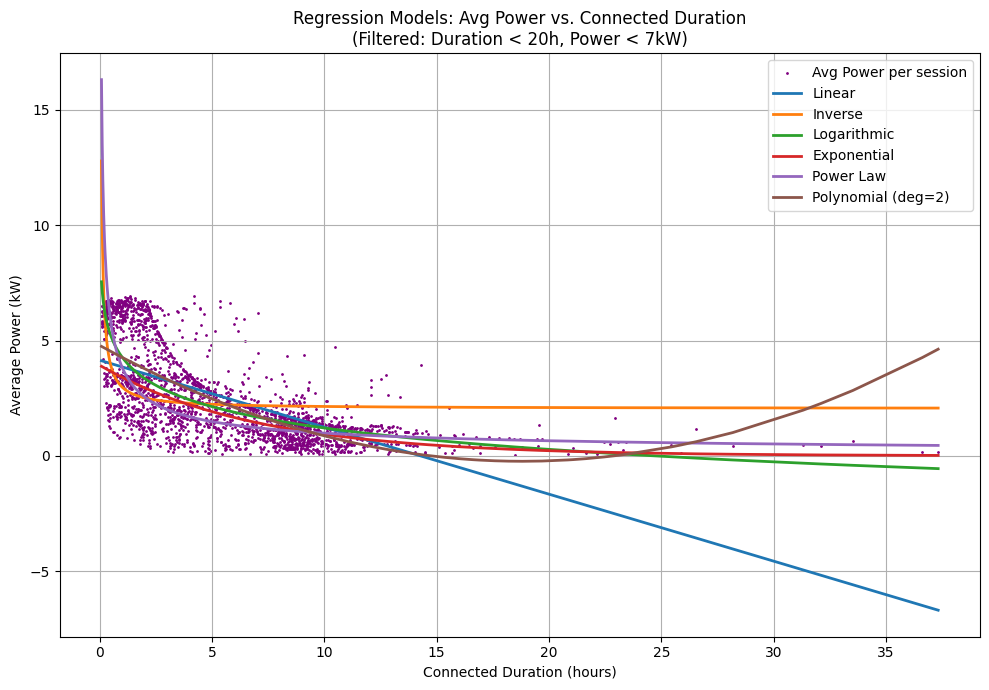

Model Performance (Filtered Data: Duration < 20h, Power < 7kW):

Linear                 | MSE: 2.3031 | R²: 0.4058
Inverse                | MSE: 2.9897 | R²: 0.2286
Logarithmic            | MSE: 1.9333 | R²: 0.5012
Exponential            | MSE: 2.2660 | R²: 0.4153
Power Law              | MSE: 3.1066 | R²: 0.1984
Polynomial (deg=2)     | MSE: 1.9586 | R²: 0.4946


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# === Data Preparation ===
average_power = y_test / X_test['connected_duration_hours']
connected_duration = X_test['connected_duration_hours']

# Apply filters: avg power 0–7 kW, duration < 20h
mask = (
    (connected_duration > 0) &
    (connected_duration < 40) &
    (average_power > 0) &
    (average_power < 7)
)
x = connected_duration[mask].values.reshape(-1, 1)
y = average_power[mask].values
x_flat = x.flatten()

# === Results Dictionary ===
results = {}

def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results[name] = (mse, r2)

# === Prepare sorted x for smooth lines ===
x_sorted = np.sort(x_flat)
x_sorted_reshaped = x_sorted.reshape(-1, 1)

# === Plot Setup ===
plt.figure(figsize=(10, 7))
plt.scatter(x, y, color='purple', s=1, label='Avg Power per session')

# === 1. Linear ===
model_lin = LinearRegression()
model_lin.fit(x, y)
y_pred_lin = model_lin.predict(x)
evaluate("Linear", y, y_pred_lin)
plt.plot(x_sorted, model_lin.predict(x_sorted_reshaped), label="Linear", linewidth=2)

# === 2. Inverse ===
x_inv = 1 / x
model_inv = LinearRegression()
model_inv.fit(x_inv, y)
y_pred_inv = model_inv.predict(x_inv)
evaluate("Inverse", y, y_pred_inv)
plt.plot(x_sorted, model_inv.predict(1 / x_sorted_reshaped), label="Inverse", linewidth=2)

# === 3. Logarithmic ===
x_log = np.log(x)
model_log = LinearRegression()
model_log.fit(x_log, y)
y_pred_log = model_log.predict(x_log)
evaluate("Logarithmic", y, y_pred_log)
plt.plot(x_sorted, model_log.predict(np.log(x_sorted_reshaped)), label="Logarithmic", linewidth=2)

# === 4. Exponential ===
y_log = np.log(y)
model_exp = LinearRegression()
model_exp.fit(x, y_log)
y_pred_exp = np.exp(model_exp.predict(x))
evaluate("Exponential", y, y_pred_exp)
plt.plot(x_sorted, np.exp(model_exp.predict(x_sorted_reshaped)), label="Exponential", linewidth=2)

# === 5. Power Law ===
model_pow = LinearRegression()
model_pow.fit(np.log(x), np.log(y))
y_pred_pow = np.exp(model_pow.predict(np.log(x)))
evaluate("Power Law", y, y_pred_pow)
plt.plot(x_sorted, np.exp(model_pow.predict(np.log(x_sorted_reshaped))), label="Power Law", linewidth=2)

# === 6. Polynomial (deg 2) ===
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)
model_poly = LinearRegression()
model_poly.fit(x_poly, y)
y_pred_poly = model_poly.predict(x_poly)
evaluate("Polynomial (deg=2)", y, y_pred_poly)
x_sorted_poly = poly.transform(x_sorted_reshaped)
plt.plot(x_sorted, model_poly.predict(x_sorted_poly), label="Polynomial (deg=2)", linewidth=2)

# === Final Plot Styling ===
plt.xlabel('Connected Duration (hours)')
plt.ylabel('Average Power (kW)')
plt.title('Regression Models: Avg Power vs. Connected Duration\n(Filtered: Duration < 20h, Power < 7kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print Model Performance ===
print("Model Performance (Filtered Data: Duration < 20h, Power < 7kW):\n")
for name, (mse, r2) in results.items():
    print(f"{name:22s} | MSE: {mse:.4f} | R²: {r2:.4f}")



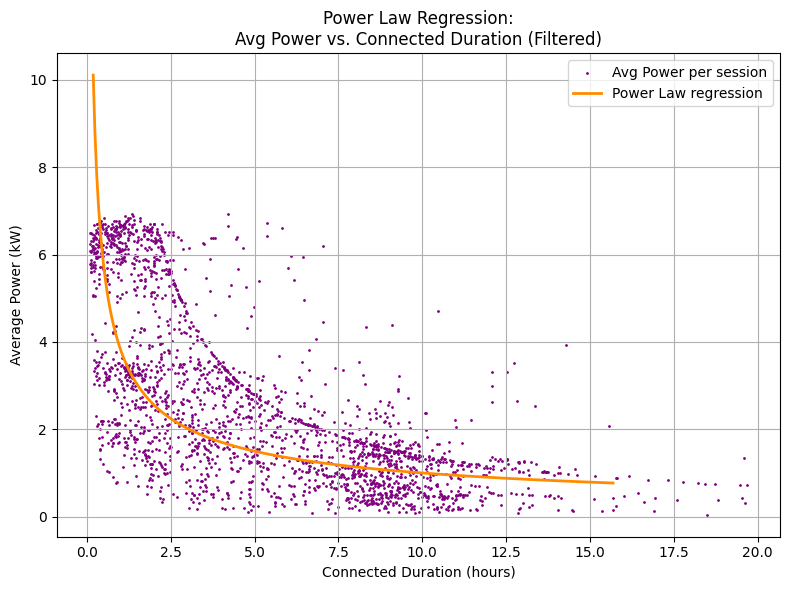

Power Law Regression:
MSE = 3.0679
R²  = 0.2073


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data
average_power = y_test / X_test['connected_duration_hours']
connected_duration = X_test['connected_duration_hours']

# Filter: duration < 20h, power between 0 and 7
mask = (
    (connected_duration > 0) &
    (connected_duration < 20) &
    (average_power > 0) &
    (average_power < 7)
)
x = connected_duration[mask].values.reshape(-1, 1)
y = average_power[mask].values

# Log-transform both x and y
log_x = np.log(x)
log_y = np.log(y)

# Fit power law: log(y) = β0 + β1 * log(x)
model_pow = LinearRegression()
model_pow.fit(log_x, log_y)

# Define x-range for regression line: within data's 1st–99th percentiles
x_p1, x_p99 = np.percentile(x, [1, 99])
x_range = np.linspace(x_p1, x_p99, 300).reshape(-1, 1)

# Predict regression line
y_pred_log = model_pow.predict(np.log(x_range))
y_pred = np.exp(y_pred_log)

# Evaluate model
y_pred_all = np.exp(model_pow.predict(log_x))
mse = mean_squared_error(y, y_pred_all)
r2 = r2_score(y, y_pred_all)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='purple', s=1, label='Avg Power per session')
plt.plot(x_range, y_pred, color='darkorange', linewidth=2, label='Power Law regression')

# Labeling
plt.xlabel('Connected Duration (hours)')
plt.ylabel('Average Power (kW)')
plt.title('Power Law Regression:\nAvg Power vs. Connected Duration (Filtered)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print model performance
print("Power Law Regression:")
print(f"MSE = {mse:.4f}")
print(f"R²  = {r2:.4f}")


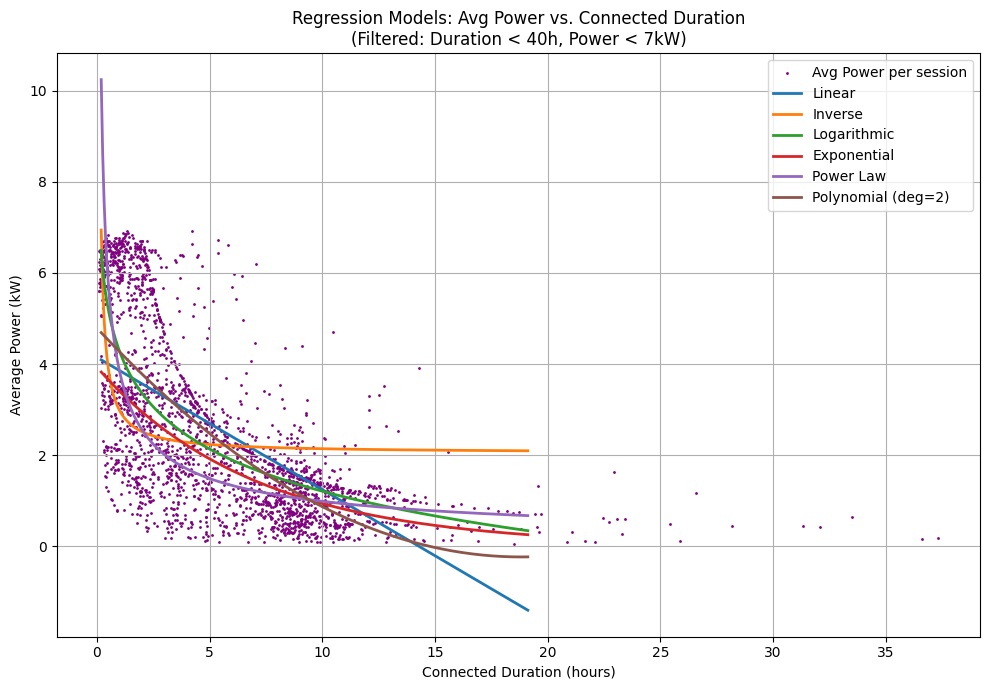

Model Performance (Filtered Data: Duration < 40h, Power < 7kW):

Linear                 | MSE: 2.3031 | R²: 0.4058
Inverse                | MSE: 2.9897 | R²: 0.2286
Logarithmic            | MSE: 1.9333 | R²: 0.5012
Exponential            | MSE: 2.2660 | R²: 0.4153
Power Law              | MSE: 3.1066 | R²: 0.1984
Polynomial (deg=2)     | MSE: 1.9586 | R²: 0.4946


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# === Data Preparation ===
average_power = y_test / X_test['connected_duration_hours']
connected_duration = X_test['connected_duration_hours']

# Apply filters: avg power 0–7 kW, duration < 40h
mask = (
    (connected_duration > 0) &
    (connected_duration < 40) &
    (average_power > 0) &
    (average_power < 7)
)
x = connected_duration[mask].values.reshape(-1, 1)
y = average_power[mask].values

# === Results Dictionary ===
results = {}

def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results[name] = (mse, r2)

# === Define smooth x-range only within filtered data ===
x_min, x_max = np.percentile(x, [1, 99])
x_smooth = np.linspace(x_min, x_max, 300).reshape(-1, 1)

# === Plot Setup ===
plt.figure(figsize=(10, 7))
plt.scatter(x, y, color='purple', s=1, label='Avg Power per session')

# === 1. Linear ===
model_lin = LinearRegression()
model_lin.fit(x, y)
y_pred_lin = model_lin.predict(x)
evaluate("Linear", y, y_pred_lin)
plt.plot(x_smooth, model_lin.predict(x_smooth), label="Linear", linewidth=2)

# === 2. Inverse ===
x_inv = 1 / x
model_inv = LinearRegression()
model_inv.fit(x_inv, y)
y_pred_inv = model_inv.predict(x_inv)
evaluate("Inverse", y, y_pred_inv)
plt.plot(x_smooth, model_inv.predict(1 / x_smooth), label="Inverse", linewidth=2)

# === 3. Logarithmic ===
x_log = np.log(x)
model_log = LinearRegression()
model_log.fit(x_log, y)
y_pred_log = model_log.predict(x_log)
evaluate("Logarithmic", y, y_pred_log)
plt.plot(x_smooth, model_log.predict(np.log(x_smooth)), label="Logarithmic", linewidth=2)

# === 4. Exponential ===
y_log = np.log(y)
model_exp = LinearRegression()
model_exp.fit(x, y_log)
y_pred_exp = np.exp(model_exp.predict(x))
evaluate("Exponential", y, y_pred_exp)
plt.plot(x_smooth, np.exp(model_exp.predict(x_smooth)), label="Exponential", linewidth=2)

# === 5. Power Law ===
model_pow = LinearRegression()
model_pow.fit(np.log(x), np.log(y))
y_pred_pow = np.exp(model_pow.predict(np.log(x)))
evaluate("Power Law", y, y_pred_pow)
plt.plot(x_smooth, np.exp(model_pow.predict(np.log(x_smooth))), label="Power Law", linewidth=2)

# === 6. Polynomial (deg 2) ===
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)
model_poly = LinearRegression()
model_poly.fit(x_poly, y)
y_pred_poly = model_poly.predict(x_poly)
evaluate("Polynomial (deg=2)", y, y_pred_poly)
x_smooth_poly = poly.transform(x_smooth)
plt.plot(x_smooth, model_poly.predict(x_smooth_poly), label="Polynomial (deg=2)", linewidth=2)

# === Final Plot Styling ===
plt.xlabel('Connected Duration (hours)')
plt.ylabel('Average Power (kW)')
plt.title('Regression Models: Avg Power vs. Connected Duration\n(Filtered: Duration < 40h, Power < 7kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print Model Performance ===
print("Model Performance (Filtered Data: Duration < 40h, Power < 7kW):\n")
for name, (mse, r2) in results.items():
    print(f"{name:22s} | MSE: {mse:.4f} | R²: {r2:.4f}")


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load your DataFrame (assuming you've already loaded it into 'df')
# df = pd.read_csv('your_data.csv')  # Uncomment and adjust if needed

# 2. Convert time columns to datetime using doneChargingTime instead of disconnectTime
df['connectionTime'] = pd.to_datetime(df['connectionTime'],
                                      format='%a, %d %b %Y %H:%M:%S GMT',
                                      errors='coerce')
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'],
                                        format='%a, %d %b %Y %H:%M:%S GMT',
                                        errors='coerce')

# 3. Drop rows with NaN values in doneChargingTime (and optionally other critical columns)
df = df.dropna(subset=['doneChargingTime', 'connectionTime', 'kWhDelivered'])

# 4. Create a numeric feature: total charged duration (hours) using doneChargingTime
df['charged_duration_hours'] = (df['doneChargingTime'] - df['connectionTime']).dt.total_seconds() / 3600

# 5. Define features (X) and target (y)
X = df[['charged_duration_hours']]  # You could add more features here
y = df['kWhDelivered']

# 6. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7. Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 8. Make predictions on the test set
y_pred = model.predict(X_test)

# 9. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== Model Evaluation ===")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R-squared (R²):         {r2:.3f}")
print("========================\n")

print("=== Model Coefficients ===")
print(f"Coefficient for charged_duration_hours: {model.coef_[0]:.3f}")
print(f"Intercept:                                {model.intercept_:.3f}")


=== Model Evaluation ===
Mean Squared Error (MSE): 29.130
R-squared (R²):         0.317

=== Model Coefficients ===
Coefficient for charged_duration_hours: 1.270
Intercept:                                4.804


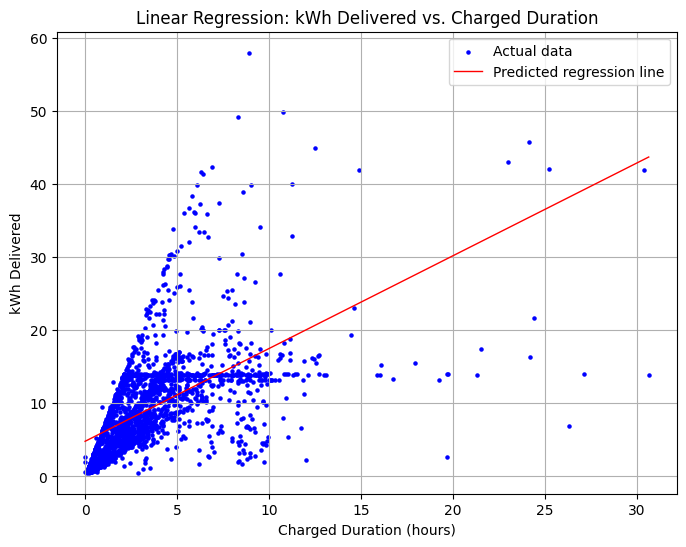

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Predict on the test set using your trained model
y_pred = model.predict(X_test)

# 2. Create a scatter plot for the actual test data using 'charged_duration_hours'
plt.figure(figsize=(8, 6))
plt.scatter(X_test['charged_duration_hours'], y_test, color='blue', s=5, label='Actual data')

# 3. Sort the test set by 'charged_duration_hours' to correctly plot the regression line
X_test_sorted = X_test.sort_values(by='charged_duration_hours')
y_pred_sorted = model.predict(X_test_sorted)

# 4. Plot the regression line
plt.plot(X_test_sorted['charged_duration_hours'], y_pred_sorted, color='red', linewidth=1, label='Predicted regression line')

# 5. Label the axes and add a title
plt.xlabel('Charged Duration (hours)')
plt.ylabel('kWh Delivered')
plt.title('Linear Regression: kWh Delivered vs. Charged Duration')
plt.legend()
plt.grid(True)

# 6. Display the plot
plt.show()
